In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import leastsq,curve_fit

In [2]:
#analysis_master_path='Y:/Rb/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\

exp_id='2018_02_09_12_10_31_Red X scan'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)

C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [3]:
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()
retention = q.apply_thresholds()
np.squeeze(retention['retention'])

array([[ 0.38709677,  0.        ,  0.01333333,  0.        ,  0.        ],
       [ 0.15454545,  0.02631579,  0.        ,  0.        ,  0.        ],
       [ 0.02631579,  0.15789474,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.31132075,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.43243243,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.24770642,  0.01333333,  0.        ,  0.        ],
       [ 0.        ,  0.13043478,  0.11842105,  0.        ,  0.        ],
       [ 0.        ,  0.04385965,  0.30666667,  0.        ,  0.        ],
       [ 0.        ,  0.00892857,  0.51315789,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.48684211,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.28947368,  0.        ,  0.        ],
       [ 0.        ,  0.008     ,  0.10526316,  0.19047619,  0.        ],
       [ 0.        ,  0.00819672,  0.        ,  0.27777778,  0.        ],
       [ 0.        ,  0.00793651,  0. 

In [4]:
tbl_str = "ivar:\t{0:.2f}\tretention:{1:.3f} +- {2:.3f}"
for i in range(len(retention['retention'].flatten())):
    print(tbl_str.format(
        retention['ivar'].flatten()[i],
        retention['retention'].flatten()[i],
        retention['error'].flatten()[i]
    ))

ivar:	-2400.00	retention:0.387 +- 0.004
ivar:	-2400.00	retention:0.000 +- 0.004
ivar:	-2400.00	retention:0.013 +- 0.004
ivar:	-2400.00	retention:0.000 +- 0.004
ivar:	-2400.00	retention:0.000 +- 0.004
ivar:	-2375.00	retention:0.155 +- 0.011
ivar:	-2375.00	retention:0.026 +- 0.011
ivar:	-2375.00	retention:0.000 +- 0.011
ivar:	-2375.00	retention:0.000 +- 0.011
ivar:	-2375.00	retention:0.000 +- 0.011
ivar:	-2350.00	retention:0.026 +- 0.027
ivar:	-2350.00	retention:0.158 +- 0.027
ivar:	-2350.00	retention:0.000 +- 0.027
ivar:	-2350.00	retention:0.000 +- 0.027
ivar:	-2350.00	retention:0.000 +- 0.027
ivar:	-2325.00	retention:0.000 +- 0.038
ivar:	-2325.00	retention:0.311 +- 0.038
ivar:	-2325.00	retention:0.000 +- 0.038
ivar:	-2325.00	retention:0.000 +- 0.038
ivar:	-2325.00	retention:0.000 +- 0.038
ivar:	-2300.00	retention:0.000 +- 0.040
ivar:	-2300.00	retention:0.432 +- 0.040
ivar:	-2300.00	retention:0.000 +- 0.040
ivar:	-2300.00	retention:0.000 +- 0.040
ivar:	-2300.00	retention:0.000 +- 0.040


In [5]:
def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

<IPython.core.display.Javascript object>


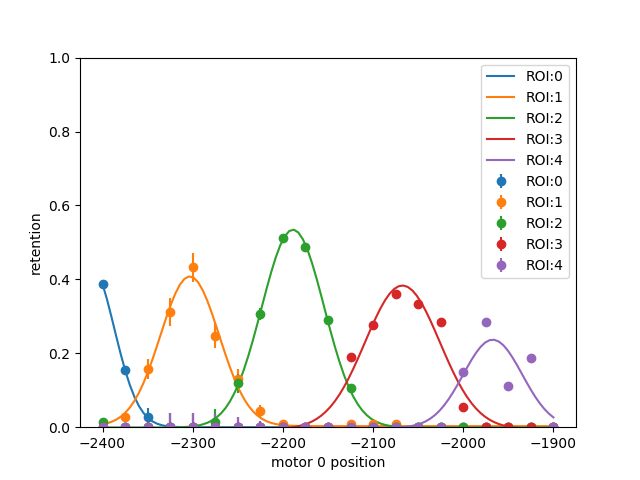

ROI:0, amplitude : 0.443590645481, location: -2414.02196693 , sigma:38.0193165386, offset:-8.7876624749e-05
ROI:1, amplitude : 0.405154355845, location: -2303.23987943 , sigma:46.0532209202, offset:0.00288337132731
ROI:2, amplitude : 0.535467165636, location: -2188.83522053 , sigma:49.1088736362, offset:-0.000850481770124
ROI:3, amplitude : 0.388698611615, location: -2067.44405672 , sigma:58.563774947, offset:-0.00528742252069
ROI:4, amplitude : 0.238891091528, location: -1967.33241939 , sigma:46.1825209054, offset:-0.00205157398513


In [14]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
fig, ax = plt.subplots()
fit_guesses=[0.5,-2200,50,0]
roi_dependency=[0,100,0,0]
fitted_parameters=[]
for roi in [0,1,2,3,4]:
    
    data = []
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
    guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
    fit = curve_fit(gaussian,data,reten,guesses)
    print "ROI:{}, amplitude : {}, location: {} , sigma:{}, offset:{}".format(roi,fit[0][0],fit[0][1],fit[0][2],fit[0][3])
    fitted_parameters.append(fit[0])
    #print fit[0]
    xarray=np.linspace(np.min(data),np.max(data),100)
    yfit=gaussian(xarray, np.float(fit[0][0]),np.float(fit[0][1]),np.float(fit[0][2]),np.float(fit[0][3]))
    plt.plot(xarray,yfit,label="ROI:{}".format(roi),color=colors[roi])

plt.show()
ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('retention')
ax.legend()

In [23]:
print np.mean([0.0133514209878,0.0130698041537])

0.0132106125707
